# Predicting Bike Rentals
In this project we use a bike sharing data from Washington, D.C. The District collects detailed data on the number of bicycles people rent by the hour and day. The data is made available by the <a href="http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">the University of California, Irvine's website</a>

It is a CSV file containing following columns:
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

We will try to predict the total number of bikes people rented in a given hour - column `cnt` - using all other columns besides `casual` and `registered` as these sum up to `cnt`.

The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

## 1. Import & Prepare Data

In [1]:
import pandas as pd
bike_rentals = pd.read_csv('bike_rental_hour.csv')
# drop unused columns
bike_rentals = bike_rentals.drop(columns=['casual','registered'])

First we print some rows of the dataset and plot the distribution of the target column (cnt) in a histogram. 

In [2]:
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14


In [3]:
import matplotlib.pyplot as plt
plt.hist(bike_rentals.cnt)
plt.show()

<Figure size 640x480 with 1 Axes>

By visualizing the data we can move forward and choose other columns that will not be useful for our prediciton. Two good candidates are `instant`, which is a sequential ID and `dteday` which is also sequential and depicted more usefully by other time variables as `year`, `hour` or `month` 

In [4]:
bike_rentals = bike_rentals.drop(columns=['instant','dteday'])

We can also visualize the distribution of bike rents per hour of the day - we see that most of the rents occur at 17 ad 18h - the typical rush hour, where people probably rent a bike to avoid the intense traffic.

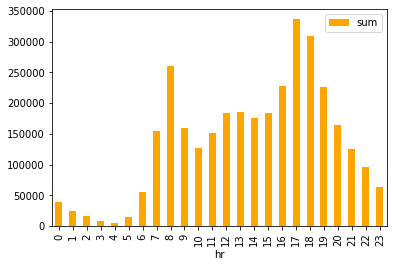

In [5]:
df_hourly=bike_rentals.groupby('hr').agg(['sum']).reset_index()
df_hourly.plot(x='hr', y='cnt',kind="bar",color='orange')
plt.show()

As a next step we can check the correlation between the target value and the other columns, taking care to remove `casual` and `registered` and then plot a heatmap of the correlations to `cnt`.

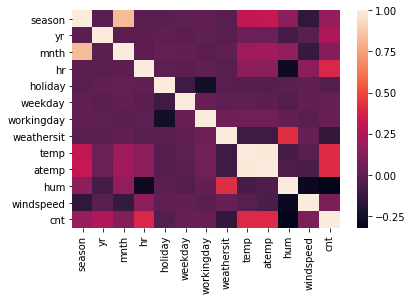

In [6]:
import seaborn as sns

corr_all = bike_rentals.corr()
ax = sns.heatmap(corr_all)

In [7]:
corr_cnt = corr_all.cnt
#absolute values of correlations to cnt
corr_cnt = corr_cnt.abs()
sorted_corrs = corr_cnt.sort_values()

In [8]:
sorted_corrs

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
cnt           1.000000
Name: cnt, dtype: float64

We can see from both the heatmap and the sorted corrs that the columns with the highest correlations are atemp, temp and hr - It is clear that atemp and temp exibit a high collinearity and we can remove one of these columns without losing valuable information - I decide to remove the temp column as the atemp is more precise.

In [9]:
bike_rentals = bike_rentals.drop(columns=['temp'])

After `temp`, the feature with the highest correlation to `cnt` is `hr`. This variable is cyclic, so the model should be able to capture the this cyclicity. One way to approach this problem is to introduce some order into the process by creating a new column with labels for **morning**, **afternoon**, **evening**, and **night**. This will bundle similar times together, enabling the model to make better decisions. For this purpose I have created a function and apply it to a new column called `time_label`

In [10]:
def assign_label(hour):
    if hour in range(6,12):
        return 1
    elif hour in range(12,18):
        return 2
    elif hour in range(18,24):
        return 3
    elif hour in range(0,6):
        return 4

In [11]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals = bike_rentals.drop(columns=['hr'])

In [12]:
bike_rentals.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,time_label
0,1,0,1,0,6,0,1,0.2879,0.81,0.0,16,4
1,1,0,1,0,6,0,1,0.2727,0.80,0.0,40,4
2,1,0,1,0,6,0,1,0.2727,0.80,0.0,32,4
3,1,0,1,0,6,0,1,0.2879,0.75,0.0,13,4
4,1,0,1,0,6,0,1,0.2879,0.75,0.0,1,4


## 2. Applying ML Models
Before we apply the ML models to the data we split  it in train and test sets. By default, scikit-learn will make random partitions for the two subsets. However, we can also specify a random state for the operation.

In [13]:
import sklearn.model_selection as model_selection

train, test = model_selection.train_test_split(bike_rentals, train_size=0.8,test_size=0.2, random_state=1)

In [14]:
# "sanity check" to see if the length is as expected
print(bike_rentals.shape[0])
print(train.shape[0] + test.shape[0])

17379
17379


Since we have removed in the last section all the unecessary columns, we can define our features and target as folows:

In [15]:
features = bike_rentals.columns.tolist()
features.remove('cnt')
target = 'cnt'

In [16]:
features

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

### 2.1 Linear Regression
At first we apply a linear regression model with different features. For the error metric we use RMSE, which represents the sample standard deviation of the differences between predicted values and observed values. We cannot use ROC-AUC score here as we are trying to solve a regression and not a classification.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train[features], train[target])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)

print('Train RMSE:',train_rmse)
print('Test RMSE:',test_rmse)

Train RMSE: 138.68470430290174
Test RMSE: 139.99498883893978


Both predictions for train and test have very similar errors

### 2.2 Decision Tree
Now we test performance for the same features using a Decision Tree model

In [18]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1)
clf.fit(train[features], train[target])

train_predictions = clf.predict(train[features])
test_predictions = clf.predict(test[features])

train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)

print('Train RMSE:',train_rmse)
print('Test RMSE:',test_rmse)

Train RMSE: 26.089443581428664
Test RMSE: 153.57735425488667


In this case the train prediction has a very low error, but the test prediction has a much higher one - which clearly shows that the model is **overfitting**

### 2.3 Random Forests
Here we use a Random Forest model, which is a much more complex model and improves the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression and overfit less than simple Decision Trees

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(n_estimators=10, random_state=1, min_samples_leaf=10)

clf2.fit(train[features], train[target])

train_predictions = clf2.predict(train[features])
test_predictions = clf2.predict(test[features])

train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)

print('Train RMSE:',train_rmse)
print('Test RMSE:',test_rmse)

Train RMSE: 101.77792186272643
Test RMSE: 148.77524154617637


## 3. Applying ML Models for Different Features Groups
Here we try running each of the models for different groups of features - from one (highest correlation) to n (all features)

In [20]:
# all columns sorted from highest to lowest correlation to cnt
corr_all = bike_rentals.corr()
corr_cnt = corr_all.cnt
corr_cnt = corr_cnt.abs()
sorted_corrs = corr_cnt.sort_values(ascending=False)

In [21]:
features = sorted_corrs.index.tolist()
features = features[1:]
target = 'cnt'

### 3.1 Linear Regression

In [22]:
current_features = []
lr_rmse_list = []
for f in features:
    current_features.append(f)
    
    model = LinearRegression()
    model.fit(train[current_features], train[target])

    train_predictions = model.predict(train[current_features])
    test_predictions = model.predict(test[current_features])

    train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
    test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)
    
    print('{} features - train RMSE: {} - test RMSE: {} '.format(len(current_features),train_rmse,test_rmse))
    
    lr_rmse_list.append(test_rmse)

1 features - train RMSE: 165.94002953068124 - test RMSE: 167.06817058160027 
2 features - train RMSE: 152.74406057735817 - test RMSE: 154.60614876502132 
3 features - train RMSE: 145.63521192096692 - test RMSE: 147.4115770853766 
4 features - train RMSE: 140.424535529987 - test RMSE: 141.25352174999034 
5 features - train RMSE: 138.90163416629022 - test RMSE: 140.15339649709398 
6 features - train RMSE: 138.89248005006326 - test RMSE: 140.16815161924643 
7 features - train RMSE: 138.89148467368204 - test RMSE: 140.16604595700977 
8 features - train RMSE: 138.83854261853227 - test RMSE: 140.01724873852953 
9 features - train RMSE: 138.7438646845343 - test RMSE: 140.04700964343152 
10 features - train RMSE: 138.73390020557275 - test RMSE: 140.02656413655998 
11 features - train RMSE: 138.68470430290174 - test RMSE: 139.99498883893978 


### 3.2 Decision Tree

In [23]:
current_features = []
dt_rmse_list = []
for f in features:
    current_features.append(f)
    
    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(train[current_features], train[target])

    train_predictions = clf.predict(train[current_features])
    test_predictions = clf.predict(test[current_features])

    train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
    test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)
    
    print('{} features - train RMSE: {} - test RMSE: {} '.format(len(current_features),train_rmse,test_rmse))
    
    dt_rmse_list.append(test_rmse)

1 features - train RMSE: 237.57064826715282 - test RMSE: 239.12653915055515 
2 features - train RMSE: 179.38579886637547 - test RMSE: 181.60353541065183 
3 features - train RMSE: 174.84059899571926 - test RMSE: 185.8323932094129 
4 features - train RMSE: 152.6412019936596 - test RMSE: 166.2384140299542 
5 features - train RMSE: 126.43449378979062 - test RMSE: 156.6318833857923 
6 features - train RMSE: 108.91799159479882 - test RMSE: 155.54932171007658 
7 features - train RMSE: 84.63345195412565 - test RMSE: 151.71234553675046 
8 features - train RMSE: 35.76494868360347 - test RMSE: 157.52192205008205 
9 features - train RMSE: 35.504290282970686 - test RMSE: 161.13494012722495 
10 features - train RMSE: 31.463100712838685 - test RMSE: 154.30613094861596 
11 features - train RMSE: 26.089443581428664 - test RMSE: 154.08536707041458 


### 3.3 Random Forests

In [24]:
current_features = []
rf_rmse_list = []
for f in features:
    current_features.append(f)
    
    clf2 = RandomForestClassifier(n_estimators=10, random_state=1, min_samples_leaf=2)
    clf2.fit(train[current_features], train[target])

    train_predictions = clf2.predict(train[current_features])
    test_predictions = clf2.predict(test[current_features])

    train_rmse = mean_squared_error(train[target],train_predictions) ** (1/2)
    test_rmse = mean_squared_error(test[target],test_predictions) ** (1/2)
    
    print('{} features - train RMSE: {} - test RMSE: {} '.format(len(current_features),train_rmse,test_rmse))
    
    rf_rmse_list.append(test_rmse)

1 features - train RMSE: 229.14844595927306 - test RMSE: 230.4837304453397 
2 features - train RMSE: 163.24764887868295 - test RMSE: 162.85597638674233 
3 features - train RMSE: 163.36942298526856 - test RMSE: 182.42199256584058 
4 features - train RMSE: 141.78809992687903 - test RMSE: 165.24294716577836 
5 features - train RMSE: 125.0730630174617 - test RMSE: 159.17739487117726 
6 features - train RMSE: 111.992268873436 - test RMSE: 156.44140474480227 
7 features - train RMSE: 97.98612152498082 - test RMSE: 153.1458855322795 
8 features - train RMSE: 65.81614117623154 - test RMSE: 157.84835441633456 
9 features - train RMSE: 62.21593664057131 - test RMSE: 155.19813517647518 
10 features - train RMSE: 59.35762666171552 - test RMSE: 149.99279902162945 
11 features - train RMSE: 53.91283146996212 - test RMSE: 146.29793972971714 


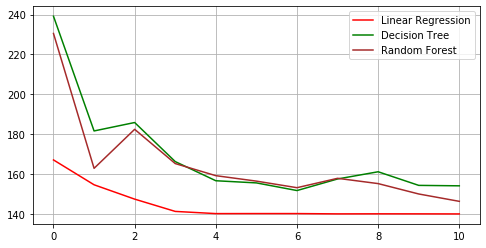

In [25]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,4))
plt.plot(lr_rmse_list, color='red', label='Linear Regression')
plt.plot(dt_rmse_list, color='green', label='Decision Tree')
plt.plot(rf_rmse_list, color='brown', label='Random Forest')
plt.legend(loc='upper right')
plt.grid()
plt.show()

The plot shows that Linear Regression has better results (smaller RMSEs) for all feature combinations